In [8]:
import dvc.api
import flatten_dict
import matplotlib as mpl
import polars as pl
import seaborn as sea

In [9]:
%matplotlib inline

In [5]:
pl.Config.set_fmt_str_lengths(500)

polars.config.Config

In [3]:
branch_a = "dvc-base-model"
branch_b = "dvc-complex-model"

# Бинарная классификация SMS сообщени на спам и не спам

Примеры данных из train.

In [10]:
data = pl.read_parquet(dvc.api.read("data/dvc/data/train.parquet", rev=branch_a, mode="rb"))

In [11]:
data.head(n=5)

target,text
i8,str
0,"""Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."""
1,"""Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"""
0,"""U dun say so early hor... U c already then say..."""
0,"""Nah I don't think he goes to usf, he lives around here though"""
0,"""Even my brother is not like to speak with me. They treat me like aids patent."""


Распредление target.

<Axes: xlabel='target', ylabel='count'>

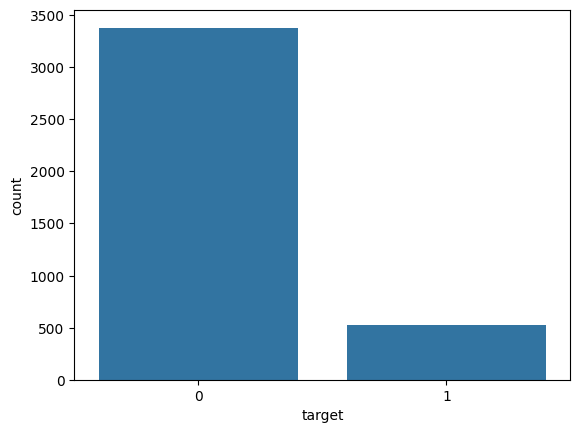

In [14]:
sea.barplot(data.group_by("target").len(name="count"), x="target", y="count")

# Ветки

In [11]:
print(branch_a, " vs ", branch_b)

dvc-base-model  vs  dvc-complex-model


Модели: 

* Логистическая регрессия с Tf-Idf (dvc-base-model).
* Случайный лес с truncated SVD поверх Tf-Idf (dvc-complex-model).

# Параметры

In [12]:
params_a = flatten_dict.flatten(dvc.api.params_show(rev=branch_a), reducer="dot")
params_b = flatten_dict.flatten(dvc.api.params_show(rev=branch_b), reducer="dot")

In [13]:
max_length = max(
    max(map(len, map(str, params_a.values()))), max(map(len, map(str, params_b.values())))
)

max_key_length = max(
    max(map(len, map(str, params_a.keys()))), max(map(len, map(str, params_b.keys())))
)

In [14]:
print(f"{'Name':<{max_key_length}} {branch_a:<{max_length}} {branch_b:<{max_length}}")

for key in sorted(set(params_a.keys()).union(params_b.keys())):
    is_a_missing = False
    is_b_missing = False

    if key not in params_a:
        is_a_missing = True

    val_a = params_a.get(key)

    if key not in params_b:
        is_b_missing = True

    val_b = params_b.get(key)

    if is_a_missing and is_b_missing or val_a == val_b:
        continue

    if is_a_missing:
        val_a = "-"
    if is_b_missing:
        val_b = "-"

    print(f"{key:<{max_key_length}} {val_a:<{max_length}} {val_b:<{max_length}}")

Name                               dvc-base-model                                                       dvc-complex-model                                                   
model.cls.estimator.C              100                                                                  -                                                                   
model.cls.estimator._target_       sklearn.linear_model.LogisticRegression                              sklearn.ensemble.RandomForestClassifier                             
model.cls.estimator.max_depth      -                                                                    6                                                                   
model.cls.estimator.n_estimators   -                                                                    100                                                                 
model.cls.estimator.n_jobs         -                                                                    -1                             

#  Метрики

Метрики на тесте и валидации получились хуже чем с базовой моделью.

In [15]:
metrics_a = dvc.api.metrics_show(rev=branch_a)
metrics_b = dvc.api.metrics_show(rev=branch_b)

In [16]:
print(f"{'Name':<20} {branch_a:<30} {branch_b:<30} {'Diff':<30}")

for metric_name in metrics_a:
    val_a = metrics_a[metric_name]
    val_b = metrics_b[metric_name]
    print(f"{metric_name:<20} {val_a:<30.4f} {val_b:<30.4f} {val_b - val_a:<30.4f}")

Name                 dvc-base-model                 dvc-complex-model              Diff                          
val_roc_auc          0.9941                         0.9723                         -0.0217                       
test_roc_auc         0.9897                         0.9745                         -0.0152                       
train_roc_auc        0.9896                         0.9980                         0.0084                        
